In [224]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

# Incorporating pose and court information
## (Generating and separating pose into top and bottom)

In [ ]:
from ai_badminton.pose import Pose, read_player_poses, process_pose_file
from ai_badminton.court import Court, read_court
from ai_badminton.trajectory import Trajectory
from ai_badminton.video_annotator import annotate_video

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

match = 'match21'
rally = '1_02_01'

import os
matches = list('match' + str(i) for i in range(1, 23))

for match in matches:
    for video in os.listdir('/home/code-base/scratch_space/data/%s/rally_video/' % match):
        rally, _ = os.path.splitext(video)
        
        court_pts = read_court('/home/code-base/scratch_space/data/%s/court/%s.out' % (match, rally))
        corners = [court_pts[1], court_pts[2], court_pts[0], court_pts[3]]
    
        def draw_court(corners):
            # Draws the court once we have the three corners
            court = Court(corners)
            frames[-1] = court.draw_lines(frames[-1])
            plt.imshow(frames[-1])
            plt.title(match)
   
        cap = cv2.VideoCapture('/home/code-base/scratch_space/data/%s/rally_video/%s.mp4' % (match, rally))
        if cap.isOpened() is False:
            print('Error opening video stream or file')

        ret, frame = cap.read()
        fig = plt.figure()
        frames = [frame]

        draw_court(corners)
        break
court = Court(corners)

In [ ]:
import os
matches = list('match' + str(i) for i in range(1, 23))

for match in matches:
    for video in os.listdir('/home/code-base/scratch_space/data/%s/rally_video/' % match):
        rally, _ = os.path.splitext(video)
        
        court_pts = read_court('/home/code-base/scratch_space/data/%s/court/%s.out' % (match, rally))
        corners = [court_pts[1], court_pts[2], court_pts[0], court_pts[3]]
        court = Court(corners)

        print(match, rally)
        poses = process_pose_file(
            '/home/code-base/scratch_space/data/%s/poses/%s.out' % (match, rally), 
            '/home/code-base/scratch_space/data/%s/poses/%s' % (match, rally), 
            court,
            fullPose=True
        )

# Conv. nets for shuttle detection

In [ ]:
import tensorflow as tf
import cv2
import math

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.activations import *

drop = 0.3
input_layer = Input(shape=(x_train.shape[1],))
# Noising and masking is bad, because the 0's actually help detection sometimes
# x = Masking(
#     mask_value=0.,
# )(input_layer)
# x = GaussianNoise(0.01)(input_layer)

x = Reshape(
    target_shape=(num_consec, x_train.shape[1] // (num_consec))
)(input_layer)
x = Dense(
    32,
    kernel_regularizer=tf.keras.regularizers.l2(1e-5),
    activation='relu'
)(x)

conv_layers = []
for i in range(2, 5):
    z = Conv1D(
        32,
        i, 
        kernel_initializer='he_uniform',
        activation='swish',
        kernel_regularizer=tf.keras.regularizers.l2(1e-5),
    )(x)
    # z = PReLU()(z)
    z = Dense(
        4,
        kernel_regularizer=tf.keras.regularizers.l2(1e-5),
        activation='relu'
    )(z)
    z = Flatten()(z)
    # z = tf.keras.backend.max(z, axis=-1)
    conv_layers.append(z)

x = Concatenate()(conv_layers)
x = Dense(
    24,
    activation='relu',
)(x)
x = Dense(
    3
)(x)
output_layer = Softmax()(x)

model = Model(input_layer, output_layer)

In [ ]:
# from keras import objectives, backend as K
# import keras
# import tensorflow as tf

# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(
#     device_count={ 'CPU': 16 , 'GPU':4},
#     inter_op_parallelism_threads=0,
#     allow_soft_placement=True,
#     gpu_options= {'allow_growth': True, 'visible_device_list': "0,1,2,3"},
#     intra_op_parallelism_threads=0,
# ))

# K.set_session(sess)

# N-in-N-out architecture

In [ ]:
import tensorflow as tf
import cv2
import math

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.activations import *

drop = 0.1
def conv_block(x, filters, size=3):
    x = Conv1D(
        filters, size,
        kernel_initializer='he_uniform', padding='same', 
        data_format='channels_last',
        kernel_regularizer=tf.keras.regularizers.l2(1e-6))(x)
    x = Dropout(drop)(x)
    x = Activation('relu')(x)
    return x

def down_block(x, filters, repeats):
    for i in range(repeats):
        x = conv_block(x, filters, 3)
    y = AveragePooling1D(
        2, strides=2, 
        data_format='channels_last')(x)
    return y, x
    
def up_block(x, xu, filters, repeats, use_res=False, channel_first=True):
    x = concatenate([
            Conv1DTranspose(
                filters, 
                kernel_size=2, strides=2, 
                data_format='channels_last')(x), 
            xu], axis=-1)
    for i in range(repeats):
        x = conv_block(x, filters)
    return x

input_layer = Input(shape=(x_train.shape[1],))
x = Reshape(
    target_shape=(num_consec, x_train.shape[1] // (num_consec))
)(input_layer)


# # Down block
x, x1 = down_block(x, 24, 2)
x, x2 = down_block(x, 24, 2)
x, x3 = down_block(x, 24, 2)
# x, x4 = down_block(x, 80, 2)

# Bottom block
# y = [Dense(32, activation='relu')(x), Dense(32, activation='relu')(x)]
# for i in range(10):
#     x = conv_block(concatenate(y[-2:], axis=-1), 32)
#     y.append(x)

# # Up block
# x = up_block(x, x2, 16, 2)
# x = up_block(x, x1, 16, 2)

# Final output
# x = Dropout(drop)(x)
x = Flatten()(x)
x = Dense(3)(x)
output_layer = Softmax()(x)

model = Model(input_layer, output_layer)

# GRUs for shuttle detection

In [7]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
# tf.config.optimizer.set_jit(False)

In [8]:
import tensorflow as tf
import cv2
import math

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.activations import *

drop = 0.1
print(x_train.shape)
input_layer = Input(shape=(x_train.shape[1],))
# x = Masking(
#     mask_value=0.,
# )(input_layer)
# x = GaussianNoise(0.01)(input_layer)

x = input_layer

x = Reshape(
    target_shape=(num_consec, x_train.shape[1] // (num_consec))
)(x)
# x = Conv1D(filters=256, kernel_size=5, padding='same', activation='relu')(x)
# x = MaxPooling1D(pool_size=2)(x)
# x = Dense(
#     32,
#     activation='relu'
# )(x)

# x_layer = [x]
for layer in range(2):
    x = Bidirectional(GRU(
        64,
        return_sequences=True,
        # kernel_regularizer=tf.keras.regularizers.l2(1e-3),
        # dropout=drop,
    ))(x)
    # if layer > 0 and layer % 3 == 0:
    #     x = concatenate([x, x_layer[layer - 2]], axis=-1)
    # x_layer.append(x)
x = GlobalMaxPool1D()(x)
x = Dense(
    3
)(x)

output_layer = Softmax()(x)

model = Model(input_layer, output_layer)

(64268, 936)


2022-06-11 19:48:16.912054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 19:48:16.920591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 19:48:16.921580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 19:48:16.923118: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(clipnorm=2.0),#tf.keras.optimizers.SGD(lr=1e-2, momentum=0.99, nesterov=True, clipnorm=2.0),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 936)]             0         
                                                                 
 reshape (Reshape)           (None, 12, 78)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 12, 128)          55296     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 12, 128)          74496     
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                             

In [10]:
import random

p = sum(y_train > 0) / sum(y_train == 0)
subsample = []
for i in range(x_train.shape[0]):
    if random.random() < p or y_train[i]:
        subsample.append(i)
        
x_train = x_train[subsample]
y_train = y_train[subsample]

In [11]:
p = sum(y_val > 0) / sum(y_val == 0)
subsample = []
for i in range(x_val.shape[0]):
    if random.random() < p or y_val[i]:
        subsample.append(i)
        
x_val = x_val[subsample]
y_val = y_val[subsample]

In [12]:
import gc
gc.collect()

5966

In [13]:
choices = [identity, 
           drop_consecutive, 
           drop_data, 
           corrupt_consecutive, 
           corrupt_data, 
           jiggle_and_rotate, 
           drop_random_and_jiggle, 
           corrupt_random_and_jiggle, 
           drop_consecutive_and_jiggle,
           corrupt_consecutive_and_jiggle]
probs = [2, 1, 1, 1, 1, 5, 1, 1, 9, 9]
probs = [x / sum(probs) for x in probs]

def augment(x):
    aug = np.random.choice(choices, p=probs)
    if random.random() < 0.5:
        x = reflect(x)
    return scale_data(aug(x))

BATCH_SIZE = 64
def fetch_data(batch_size=BATCH_SIZE):
    global x_train, y_train
    while True:
        idx = np.random.permutation(x_train.shape[0])
        x_train, y_train = x_train[idx], y_train[idx]
        for i in range(0, x_train.shape[0], BATCH_SIZE):
            yield augment(x_train[i:i+BATCH_SIZE]), y_train[i:i+BATCH_SIZE]
        
dataset = tf.data.Dataset.from_generator(
    fetch_data,
    output_shapes=((None, x_train.shape[1]), (None,)),
    output_types=(tf.float32, tf.float32),
).prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights[0] /= 4
class_weights[1] *= 2
class_weights[2] *= 2

In [15]:
# from tensorflow.keras import backend as K
# K.set_value(model.optimizer.learning_rate, 1e-3)
import tensorflow_addons as tfa
import datetime

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    tfa.optimizers.CyclicalLearningRate(1e-3, 1e-2,
    step_size=25,
    scale_fn=lambda x: 1,
    scale_mode= 'cycle',
    name= 'CyclicalLearningRate'
))

output_dir = './tensorboard/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
        output_dir, 
        histogram_freq=1,
        profile_batch = '500,520',
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15),
    tf.keras.callbacks.ReduceLROnPlateau(patience=13),
    tf.keras.callbacks.ModelCheckpoint(filepath=f"hitnet-{num_consec}-{left_window}-{right_window}-model-best.h5", save_best_only=True),
    # lr_scheduler,
    tensorboard_callback
]

# from tensorboard.plugins import projector

# # Set up config.
# embedding_var = tf.Variable(model.layers[-2].get_weights[0][1:])

# config = projector.ProjectorConfig()
# embedding = config.embeddings.add()
# # The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
# embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
# embedding.metadata_path = 'metadata.tsv'
# projector.visualize_embeddings(log_dir, config)

2022-06-11 19:48:30.364017: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-06-11 19:48:30.364064: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-06-11 19:48:30.364105: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1630] Profiler found 1 GPUs
2022-06-11 19:48:30.364498: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/envs/ai-badminton/lib/python3.8/site-packages/cv2/../../lib64:/opt/conda/envs/ai-badminton/lib/python3.8/site-packages/cv2/../../lib64:/opt/conda/envs/ai-badminton/lib/
2022-06-11 19:48:30.465959: E tensorflow/core/profiler/internal/gpu/cupti_error_manager.cc:192] cuptiSubscribe: error 35: CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2022-06-11 19:48:30.466017: E tensorflow/core/profiler/internal/gpu/cupti_error

In [16]:
model.fit(
    dataset,
    # x_train, y_train,
    # batch_size=256, 
    steps_per_epoch=10 * x_train.shape[0] // BATCH_SIZE,
    epochs=600,
    # class_weight={i: class_weights[i] for i in range(3)},
    # shuffle=True,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/600


2022-06-11 19:48:38.352366: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


 514/3983 [==>...........................] - ETA: 35s - loss: 1.0339 - accuracy: 0.4948

2022-06-11 19:48:44.765516: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-06-11 19:48:44.765557: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-06-11 19:48:44.765639: E tensorflow/core/profiler/internal/gpu/cupti_error_manager.cc:133] cuptiGetTimestamp: ignored due to a previous error.
2022-06-11 19:48:44.765656: E tensorflow/core/profiler/internal/gpu/cupti_error_manager.cc:184] cuptiSubscribe: ignored due to a previous error.
2022-06-11 19:48:44.765663: E tensorflow/core/profiler/internal/gpu/cupti_error_manager.cc:457] cuptiGetResultString: ignored due to a previous error.
2022-06-11 19:48:44.765670: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1682] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 


 518/3983 [==>...........................] - ETA: 35s - loss: 1.0339 - accuracy: 0.4944

2022-06-11 19:48:45.018492: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-06-11 19:48:45.019062: E tensorflow/core/profiler/internal/gpu/cupti_error_manager.cc:140] cuptiFinalize: ignored due to a previous error.
2022-06-11 19:48:45.019093: E tensorflow/core/profiler/internal/gpu/cupti_error_manager.cc:457] cuptiGetResultString: ignored due to a previous error.
2022-06-11 19:48:45.019103: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error 
2022-06-11 19:48:45.085242: E tensorflow/core/profiler/internal/gpu/cupti_error_manager.cc:133] cuptiGetTimestamp: ignored due to a previous error.
2022-06-11 19:48:45.085280: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-11 19:48:45.101041: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2022-06-11 19:48:45

 530/3983 [==>...........................] - ETA: 37s - loss: 1.0333 - accuracy: 0.4947

2022-06-11 19:48:45.243651: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./tensorboard/20220611-194830/plugins/profile/2022_06_11_19_48_45

2022-06-11 19:48:45.257383: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./tensorboard/20220611-194830/plugins/profile/2022_06_11_19_48_45/ip-10-216-140-201.memory_profile.json.gz
2022-06-11 19:48:45.295715: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./tensorboard/20220611-194830/plugins/profile/2022_06_11_19_48_45
Dumped tool data for xplane.pb to ./tensorboard/20220611-194830/plugins/profile/2022_06_11_19_48_45/ip-10-216-140-201.xplane.pb
Dumped tool data for overview_page.pb to ./tensorboard/20220611-194830/plugins/profile/2022_06_11_19_48_45/ip-10-216-140-201.overview_page.pb
Dumped tool data for input_pipeline.pb to ./tensorboard/20220611-194830/plugins/profile/2022_06_11_19_48_45/ip-10-216-140-201.input

3983/3983 [==============================] - 52s 11ms/step - loss: 0.8341 - accuracy: 0.6038 - val_loss: 0.4565 - val_accuracy: 0.7982 - lr: 0.0010
Epoch 2/600
3983/3983 [==============================] - 41s 10ms/step - loss: 0.5488 - accuracy: 0.7613 - val_loss: 0.3880 - val_accuracy: 0.8319 - lr: 0.0010
Epoch 3/600
3983/3983 [==============================] - 41s 10ms/step - loss: 0.4873 - accuracy: 0.7937 - val_loss: 0.2852 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 4/600
3983/3983 [==============================] - 41s 10ms/step - loss: 0.4525 - accuracy: 0.8105 - val_loss: 0.2582 - val_accuracy: 0.8964 - lr: 0.0010
Epoch 5/600
3983/3983 [==============================] - 41s 10ms/step - loss: 0.4293 - accuracy: 0.8215 - val_loss: 0.2938 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 6/600
3983/3983 [==============================] - 41s 10ms/step - loss: 0.4133 - accuracy: 0.8292 - val_loss: 0.2291 - val_accuracy: 0.9086 - lr: 0.0010
Epoch 7/600
3983/3983 [=============================

In [17]:
# Implement temperature scaling for calibration
def temp_scaling(y_logits, y_val, max_iter=150):
    temp = tf.Variable(initial_value=1.0, trainable=True, dtype=tf.float32)
    def compute_loss():
        y_pred_model_w_temp = tf.math.divide(y_logits, temp)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(\
          tf.convert_to_tensor(tf.keras.utils.to_categorical(y_val)), \
                               y_pred_model_w_temp))
        return loss
    optimizer = tf.optimizers.Adam()
    print('Temperature Initial value: {}'.format(temp.numpy()))
    for i in range(max_iter):
        opts = optimizer.minimize(compute_loss, var_list=[temp])
    print('Temperature Final value: {}'.format(temp.numpy()))
    return temp.numpy()

from tensorflow.keras import backend as K
compute_logits = K.function([model.layers[0].input], [model.layers[-2].output])

y_logits = compute_logits(x_val)[0]
temp = temp_scaling(y_logits, y_val)

Temperature Initial value: 1.0
Temperature Final value: 1.130116581916809


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(x_val), axis=1)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred, normalize='true'))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2222
           1       0.95      0.94      0.95      1103
           2       0.92      0.92      0.92      1095

    accuracy                           0.94      4420
   macro avg       0.94      0.93      0.93      4420
weighted avg       0.94      0.94      0.94      4420

[[0.94149415 0.02205221 0.03645365]
 [0.05711695 0.93834995 0.00453309]
 [0.08127854 0.         0.91872146]]


In [19]:
os.chdir('/home/juiwang/ai-badminton/code/ai-badminton/TrackNetv2/3_in_3_out')

In [20]:
from tensorflow.python.keras.saving import hdf5_format
import h5py

# temp = 1.0
with h5py.File(f'./hitnet_conv_model_predict_direction-{num_consec}-{left_window}-{right_window}.h5', mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['temperature'] = temp

# Automatic hyperparameter tuning

In [ ]:
def build_model(hp):
    input_layer = Input(shape=(x_train.shape[1],))
    x = input_layer
    x = Reshape(
        target_shape=(num_consec, x_train.shape[1] // (num_consec))
    )(x)
    # for layer in range(hp.Choice('dense_layers', [0, 1])):
    #     x = Dense(hp.Choice('dense_units', [32, 64, 128]), activation='relu')(x)
    
    for layer in range(hp.Choice('gru_layers', [1, 2, 4])):
        x = Bidirectional(GRU(
            hp.Choice('gru_units', [16, 64, 128]),
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', [0., 1e-6, 1e-4])),
            dropout=hp.Choice('dropout', [0., 0.2])
        ))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(
        3
    )(x)

    output_layer = Softmax()(x)
    model = Model(input_layer, output_layer)
                          
    model.compile(
        optimizer=tf.keras.optimizers.Adam(clipnorm=2.0),#tf.keras.optimizers.SGD(lr=1e-2, momentum=0.99, nesterov=True, clipnorm=2.0),
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    return model
    
output_dir = './tensorboard/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    output_dir, 
    histogram_freq=1,
)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15),
    tf.keras.callbacks.ReduceLROnPlateau(patience=12),
    tensorboard_callback
]
          
import keras_tuner as kt

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=50,
#     distribution_strategy=tf.distribute.MirroredStrategy(),
    directory="tensorboard",
#     project_name="gru-model",
    overwrite=True
)
 
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                   classes=np.unique(y_train),
#                                                   y=y_train)
tuner.search(
    # x_train, 
    # y_train, 
    # epochs=1000, 
    # batch_size=1024,
    # shuffle=True,
    dataset,
    steps_per_epoch=10 * x_train.shape[0] // BATCH_SIZE,
    epochs=600,
    validation_data=(x_val, y_val),
    # class_weight={i: class_weights[i] for i in range(3)},
    callbacks=callbacks,
)
best_model = tuner.get_best_models()[0]


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
gru_layers        |2                 |?                 
gru_units         |64                |?                 
l2_reg            |1e-06             |?                 
dropout           |0                 |?                 

Epoch 1/600
   2/9626 [..............................] - ETA: 51:59 - loss: 0.8384 - accuracy: 0.6172WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0128s vs `on_train_batch_end` time: 0.6351s). Check your callbacks.


9626/9626 [==============================] - 112s 12ms/step - loss: 0.3336 - accuracy: 0.8834 - val_loss: 0.2077 - val_accuracy: 0.9234
Epoch 2/600
9626/9626 [==============================] - 109s 11ms/step - loss: 0.1874 - accuracy: 0.9297 - val_loss: 0.1792 - val_accuracy: 0.9365
Epoch 3/600
9626/9626 [==============================] - 109s 11ms/step - loss: 0.1587 - accuracy: 0.9414 - val_loss: 0.1521 - val_accuracy: 0.9461
Epoch 4/600
9626/9626 [==============================] - 109s 11ms/step - loss: 0.1412 - accuracy: 0.9487 - val_loss: 0.1456 - val_accuracy: 0.9536
Epoch 5/600
9626/9626 [==============================] - 109s 11ms/step - loss: 0.1318 - accuracy: 0.9525 - val_loss: 0.1490 - val_accuracy: 0.9495
Epoch 6/600
9626/9626 [==============================] - 109s 11ms/step - loss: 0.1225 - accuracy: 0.9558 - val_loss: 0.1515 - val_accuracy: 0.9503
Epoch 7/600
9626/9626 [==============================] - 109s 11ms/step - loss: 0.1171 - accuracy: 0.9579 - val_loss: 0.1453

# Look at mis-predicted shots

In [ ]:
os.getcwd()
os.chdir('/home/code-base/user_space/ai-badminton/notebooks')

In [ ]:
outvid = cv2.VideoWriter('./output/mispredicted.mp4', cv2.VideoWriter_fourcc('M','P','4','V'), 10, (width, height))

parent_dir = "/home/code-base/user_space/ai-badminton/notebooks/data/test_data"
base_dir = "/home/code-base/user_space/ai-badminton/notebooks/data/test_data/test_all"
for t, dirname in enumerate(os.listdir(base_dir)):
    if 'match' not in dirname:
        continue
    try:
        match, rally = dirname.split('-')
        match = 'test_' + match
        video = '%s/%s/rally_video/%s.mp4' % (base_dir, dirname, rally)
        cap = cv2.VideoCapture(video)
        
        trajectory = Trajectory(
            '%s/%s/ball_trajectory/%s_ball.csv' % (base_dir, dirname, rally),
            interp=False
        )
        hit = pd.read_csv('%s/%s/shot/%s_hit.csv' % (parent_dir, match, rally))

        poses = read_player_poses('%s/%s/poses/%s' % (base_dir, dirname, rally))
        bottom_player, top_player = poses[0], poses[1]

        x_list, y_list = [], []
        court_pts = read_court('%s/%s/court/%s.out' % (base_dir, dirname, rally))
        corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()
        court = Court([court_pts[1], court_pts[2], court_pts[0], court_pts[3]])
    except:
        print('Failed data fetch for match', dirname)
        continue
    
        
    # Identify first hit by distance to pose
    # and then alternate hits
    def dist_to_pose(pose, p):
        pose = pose.reshape(17, 2)
        p = p.reshape(1, 2)
        D = np.sum((pose - p) * (pose - p), axis=1)
        return min(D)

    y_new = np.array(hit.hit.to_numpy())
    # Majority vote for who started the rally
    # If hit number is odd, then whoever started the rally
    # is the opposite of whoever was detected.
    votes = [0, 0]
    best_dist = [1e99, 1e99]
    nhit = 0
    for i in range(y_new.shape[0]):
        if not y_new[i]:
            continue

        p = np.array([trajectory.X[i], trajectory.Y[i]])
        db = dist_to_pose(bottom_player.values[i], p)
        dt = dist_to_pose(top_player.values[i], p)
        person = 0
        if db < dt:
            person = 1
        else:
            person = 2

        if nhit % 2:
            person = 3 - person

        votes[person - 1] += 1
        best_dist[person - 1] = min(best_dist[person - 1], min(db, dt))

        nhit += 1

    if abs(votes[0] - votes[1]) < 2:
        print(match, rally, 'is hard', votes, best_dist)
    else:
        print(match, rally, 1 if votes[0] > votes[1] else 2, votes)

    last = 2 if votes[0] > votes[1] else 1
    if votes[0] == votes[1]:
        last = 1 if best_dist[0] < best_dist[1] else 2

    for i in range(y_new.shape[0]):
        if not y_new[i]:
            continue

        y_new[i] = 3 - last
        last = y_new[i]

    for i in range(num_consec):
        end = min(len(trajectory.X), len(hit.hit))-num_consec+i+1
        x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))

        # Use entire pose
        x_pose = np.hstack([bottom_player.values[i:end], top_player.values[i:end]])
        x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])

        y = y_new[i:end]
        x_list.append(x)
        y_list.append(y)

    x_t = np.hstack(x_list)
    y_t = np.max(np.column_stack(y_list[-8:-2]), axis=1)
    
    y_pred = np.argmax(model.predict(scale_data(x_t)), axis=1)

    nframes = len(hit.hit)
    is_bad = [0] * nframes
    for i in range(y_t.shape[0]-1):
        if all(y_t[i:i+3] != y_pred[i:i+3]) and y_t[i] > 0:
            for j in range(max(0, i-20), min(nframes, i+20)):
                if abs(j-i) < 8:
                    is_bad[j] = 1 + y_pred[i]

    for i in range(nframes):
        if is_bad[i]:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if is_bad[i] == 3:
                frame[-50:, -50:] = np.array([255, 0, 0])
            elif is_bad[i] == 2:
                frame[-50:, -50:] = np.array([0, 0, 255])
            elif is_bad[i] == 1:
                frame[-50:, -50:] = np.array([0, 255, 0])
                
            frame = court.draw_lines(frame)
            centre = (int(trajectory.X[i]), int(trajectory.Y[i]))
            radius = 5
            colour = (0, 255, 0)
            thickness = -1
            frame = cv2.circle(frame, centre, radius, colour, thickness)

            players = [bottom_player.values, top_player.values]
            for j in range(2):
                xy = players[j][i]
                pose = Pose()
                pose.init_from_kparray(xy)
                frame = pose.draw_skeleton(frame, colour=(128, 128 + j * 127, 128))
            outvid.write(frame)
outvid.release()

# Create network to identify who hit the shuttle

In [1]:
# make sure cudart is in the LD_LIBRARY_PATH
%env 

{'LANG': 'C.UTF-8',
 'PATH': '/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/opt/jupyterlab/bin',
 'HOME': '/home/juiwang',
 'LOGNAME': 'juiwang',
 'USER': 'juiwang',
 'SHELL': '/bin/bash',
 'INVOCATION_ID': 'ea3323e9d3154893b023913205cc1368',
 'JOURNAL_STREAM': '8:42312',
 'PYDEVD_USE_FRAME_EVAL': 'NO',
 'LD_LIBRARY_PATH': '/opt/conda/envs/ai-badminton/lib/python3.8/site-packages/cv2/../../lib64:/opt/conda/envs/ai-badminton/lib/',
 'JPY_PARENT_PID': '1765',
 'TERM': 'xterm-color',
 'CLICOLOR': '1',
 'PAGER': 'cat',
 'GIT_PAGER': 'cat',
 'MPLBACKEND': 'module://matplotlib_inline.backend_inline'}

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
import math

from ai_badminton.trajectory import Trajectory
from ai_badminton.hit_detector import AdhocHitDetector, MLHitDetector
from ai_badminton.pose import Pose, read_player_poses, process_pose_file
from ai_badminton.court import Court, read_court
from ai_badminton.video_annotator import annotate_video

In [12]:
import os
import pandas as pd
import numpy as np
import cv2
import random
from scipy.stats import mode
from scipy.ndimage.interpolation import shift
from skimage.transform import rescale, resize

def read_court(filename):
    file = open(filename, 'r')
    coordinates = [[float(x) for x in line.split(';')] for line in file]
    return coordinates

def visualize(x, y):
    print(x.shape, y.shape)
    cdict = {0: 'red', 1: 'blue', 2: 'green'}
    plt.figure()
    for g in np.unique(y):
        ix = np.where(y == g)
        plt.scatter(*x[ix, -4:, :].T, c=cdict[g], label=g)
        plt.scatter(*x[ix, 0, :].T, c=cdict[g], label=g)
    plt.show()
    
def resample(series, s):
    flatten = False
    if len(series.shape) == 1:
        series.resize((series.shape[0], 1))
        series = series.astype('float64')
        flatten = True
    series = resize(
        series, (int(s * series.shape[0]), series.shape[1]),
    )
    if flatten:
        series = series.flatten()
    return series   

eps = 1e-6
def reflect(x):
    x = np.array(x)
    idx = np.abs(x) < eps
    for i in range(0, x.shape[1], 2):
        x[:, i] = -x[:, i]
    x[idx] = 0.
    return x

# Identify first hit by distance to pose
# and then alternate hits
def dist_to_pose(pose, p):
    pose = pose.reshape(17, 2)
    p = p.reshape(1, 2)
    D = np.sum((pose - p) * (pose - p), axis=1)
    return min(D)

def scale_data(x):
    x = np.array(x)
    def scale_by_col(x, cols):
        x_ = np.array(x[:, cols])
        idx = np.abs(x_) < eps
        m, M = np.min(x_[~idx]), np.max(x_[~idx])
        x_[~idx] = (x_[~idx] - m) / (M - m) + 1
        x[:, cols] = x_
        return x

    even_cols = [2*i for i in range(x.shape[1] // 2)]
    odd_cols = [2*i+1 for i in range(x.shape[1] // 2)]
    x = scale_by_col(x, even_cols)
    x = scale_by_col(x, odd_cols)
    return x

identity = lambda x: x
def drop_consecutive(x, rep_value=0.):
    x = np.array(x)
    for i in range(x.shape[0]):
        j = random.randint(0, num_consec-1)
        x[i][max(0, 78*(j-2)):min(78*(j+2), 78*num_consec)] = rep_value
    return x

def corrupt_consecutive(x, rep_value=0.):
    x = np.array(x)
    for i in range(x.shape[0]):
        j = random.randint(0, num_consec-1)
        l, r = max(0, 78*(j-2)), min(78*(j+2), 78*num_consec)
        x[i][l:r] = np.random.rand(1, r-l)
    return x

def drop_data(x, rep_value=0, keep_prob=0.95):
    x = np.array(x)
    # Corrupt 15% of the data
    indices = np.random.choice(
        np.arange(x.size), replace=False,
        size=int(x.size * (1 - keep_prob))
    )
    x[np.unravel_index(indices, x.shape)] = rep_value
    return x

def corrupt_data(x, keep_prob=0.95):
    x = np.array(x)
    idx = np.abs(x) < eps
    # Corrupt 15% of the data
    indices = np.random.choice(
        np.arange(x.size), replace=False,
        size=int(x.size * (1 - keep_prob))
    )
    shape = x[np.unravel_index(indices, x.shape)].shape
    low, hi = max(np.min(x[:,0::2]), np.min(x[:,1::2])), min(np.max(x[:,0::2]), np.max(x[:,1::2]))
    target = np.random.rand(*shape) * (hi-low) + low
    x[np.unravel_index(indices, x.shape)] = target
    x[idx] = 0.
    return x

def jiggle_and_rotate(x):
    # Randomly shift by a vector in [0, 30]
    # and rotate by a random amount between -10 and 10 degrees
    x = np.array(x.reshape((x.shape[0], x.shape[1] // 2, 2)))
    idx = np.abs(x) < eps
    # shift does nothing when we rescale after
    # shift = np.random.rand(1, 2) * 30
    angle = (np.random.rand() - 0.5) * math.pi / 180 * 30
    rotate = np.array([[math.cos(angle), -math.sin(angle)], 
                       [math.sin(angle), math.cos(angle)]])
    a, b = np.random.rand() * 0.1, np.random.rand() * 0.1
    shear = np.array([[1+a*b, a], 
                      [b,     1]])
    x = x @ shear @ rotate
    x[idx] = 0.
    x = x.reshape((x.shape[0], x.shape[1] * 2))
    return x

drop_random_and_jiggle = lambda x: drop_data(jiggle_and_rotate(x), 0, 0.95)
corrupt_random_and_jiggle = lambda x: corrupt_data(jiggle_and_rotate(x), 0.95)
drop_consecutive_and_jiggle = lambda x: drop_consecutive(jiggle_and_rotate(x))
corrupt_consecutive_and_jiggle = lambda x: corrupt_consecutive(jiggle_and_rotate(x))

/tmp/ipykernel_982175/2660595176.py:7: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [ ]:
num_consec = 12 # Jui: read the paper for the correct parameters
left_window = 6
right_window = 0
matches = list('match' + str(i) for i in range(1, 23))

from sklearn.preprocessing import MinMaxScaler, StandardScaler, minmax_scale

manual_label = {
    ('match1', '1_02_04'): 2,
    ('match1', '1_06_08'): 1,
    ('match1', '1_02_02'): 1,
    ('match1', '1_02_01'): 2,
    ('match1', '1_03_04'): 2,
    ('match1', '1_02_03'): 1,
    ('match3', '1_08_10'): 2,
    ('match8', '3_02_00'): 2,
}

x_train, y_train = [], []
for match in matches:
    basedir = '/home/juiwang/ai-badminton/data/tracknetv2_042022/profession_dataset/%s' % match
    for video in os.listdir('%s/rally_video/' % basedir):
        if '.mp4' not in video:
            continue
        for speed in [1.0]:#[0.833, 0.9, 1.0, 1.1, 1.2]:
            rally, _ = os.path.splitext(video)
            trajectory = Trajectory(
                '%s/ball_trajectory/%s_ball.csv' % (basedir, rally),
                interp=False
            )
            hit = pd.read_csv('%s/shot/%s_hit.csv' % (basedir, rally))

            poses = read_player_poses('%s/poses/%s' % (basedir, rally))
            bottom_player, top_player = poses[0], poses[1]

            x_list, y_list = [], []
            court_pts = read_court('%s/court/%s.out' % (basedir, rally))
            corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()
            
            cap = cv2.VideoCapture('%s/rally_video/%s' % (basedir, video))
            _, frame = cap.read()
            height, width = frame.shape[:2]         
            
            hit = hit.values[:, 1]
            if speed < 1:
                # NTS: speed < 1 actually means sequence gets faster
                hit = hit + shift(hit, -1) + shift(hit, +1)
                        
            trajectory.X = resample(np.array(trajectory.X), speed)
            trajectory.Y = resample(np.array(trajectory.Y), speed)
            hit = resample(hit, speed).round()
            bottom_player = resample(bottom_player.values, speed)
            top_player = resample(top_player.values, speed)
            
            y_new = np.array(hit)
            if speed != 1:
                for i in range(y_new.shape[0] - 1):
                    if i+3 < y_new.shape[0] and y_new[i] and y_new[i+1] and y_new[i+2] and y_new[i+3]:
                        y_new[i] = y_new[i+1] = y_new[i+3] = 0.
                    if i+2 < y_new.shape[0] and y_new[i] and y_new[i+1] and y_new[i+2]:
                        y_new[i] = y_new[i+2] = 0.
                    if y_new[i] and y_new[i+1]:
                        y_new[i] = 0.
                        
            # Majority vote for who started the rally
            # If hit number is odd, then whoever started the rally
            # is the opposite of whoever was detected.
            votes = [0, 0]
            best_dist = [1e99, 1e99]
            nhit = 0
            for i in range(y_new.shape[0]):
                if not y_new[i]:
                    continue

                p = np.array([trajectory.X[i], trajectory.Y[i]])
                db = dist_to_pose(bottom_player[i], p)
                dt = dist_to_pose(top_player[i], p)
                person = 0
                if db < dt:
                    person = 1
                else:
                    person = 2

                if nhit % 2:
                    person = 3 - person

                votes[person - 1] += 1
                best_dist[person - 1] = min(best_dist[person - 1], min(db, dt))

                nhit += 1

            if abs(votes[0] - votes[1]) < 2:
                print(match, rally, 'is hard', votes, best_dist)
            else:
                print(match, rally, 1 if votes[0] > votes[1] else 2, votes)

            last = 2 if votes[0] > votes[1] else 1
            if (match, rally) in manual_label:
                last = 3 - manual_label[match, rally]
                print('Manual label applied.')
            for i in range(y_new.shape[0]):
                if not y_new[i]:
                    continue

                y_new[i] = 3 - last
                last = y_new[i]
                
            # Try to predict direction instead
            # 1 is bottom, 2 is top
            # so just fill 0s with non zero value closest to the left
            # this implies 1 is bottom -> top hit, 2 is otherwise
            # 0 is no hit
            # last = 0
            # last_id = -1
            # for i in range(y_new.shape[0]):
            #     if y_new[i] > 0:
            #         if last_id >= 0:
            #             for j in range(last_id, i):
            #                 y_new[j] = last
            #         last = y_new[i]
            #         last_id = i
            #     y_new[i] = last
                            
            for i in range(num_consec):
                end = min(len(trajectory.X), len(hit))-num_consec+i+1
                x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))

                # Use entire pose
                x_pose = np.hstack([bottom_player[i:end], top_player[i:end]])
                x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])
                print(f"Jui debug x_bird = {x_bird.shape}, x_pose = {x_pose.shape}, x = {x.shape}, corners = {corners.shape}")

                print(f"Jui debug i={i}, end={end}, len(y_new)={len(y_new)}, y_new.shape={y_new.shape}")
                y = y_new[i:end]
                x_list.append(x)
                y_list.append(y)

            x_t = np.hstack(x_list)
            if right_window > 0:
                y_t = np.max(np.column_stack(y_list[left_window:-right_window]), axis=1)
            else:
                y_t = np.max(np.column_stack(y_list[left_window:]), axis=1)
            print(f"Jui debug y_t.shape = {y_t.shape}")

                    
            # y_t = np.column_stack(y_list).astype('float')
            # y_t = mode(np.column_stack(y_list[left_window:-right_window]), axis=1).mode.flatten()
            # for i in range(y_t.shape[0]):
            #     val, cnt = np.unique(y_t[i], return_counts=True)
            #     val = val.astype('int')
            #     cnt = cnt.astype('float')
            #     y_t[i, 0:3] = 0
            #     y_t[i, val] = cnt / subwindow_size
            # y_t = y_t[:, :3]

            augmentations = [identity]# + [jiggle_and_rotate]*2# + [drop_consecutive_and_jiggle] + [corrupt_consecutive_and_jiggle]
            #+ [corrupt_and_jiggle] + [drop_and_jiggle]# + [jiggle_and_rotate] + [drop_and_jiggle] + [corrupt_and_jiggle]
            for transform in augmentations:
                x_train.append(scale_data(transform(x_t)))
                y_train.append(y_t)
                
                # x_train.append(scale_data(transform(reflect(x_t))))
                # y_train.append(y_t)

x_train = np.vstack(x_train)
y_train = np.hstack(y_train)

match1 1_03_04 2 [0, 3]
Manual label applied.
138
Jui debug x_bird = (127, 2), x_pose = (127, 68), corners = (8,), cc = (127, 8), x = (127, 78), 
Jui debug i=0, end=127, len(y_new)=138, y_new.shape=(138,)
Jui debug x_bird = (127, 2), x_pose = (127, 68), corners = (8,), cc = (127, 8), x = (127, 78), 
Jui debug i=1, end=128, len(y_new)=138, y_new.shape=(138,)
Jui debug x_bird = (127, 2), x_pose = (127, 68), corners = (8,), cc = (127, 8), x = (127, 78), 
Jui debug i=2, end=129, len(y_new)=138, y_new.shape=(138,)
Jui debug x_bird = (127, 2), x_pose = (127, 68), corners = (8,), cc = (127, 8), x = (127, 78), 
Jui debug i=3, end=130, len(y_new)=138, y_new.shape=(138,)
Jui debug x_bird = (127, 2), x_pose = (127, 68), corners = (8,), cc = (127, 8), x = (127, 78), 
Jui debug i=4, end=131, len(y_new)=138, y_new.shape=(138,)
Jui debug x_bird = (127, 2), x_pose = (127, 68), corners = (8,), cc = (127, 8), x = (127, 78), 
Jui debug i=5, end=132, len(y_new)=138, y_new.shape=(138,)
Jui debug x_bird = (

In [9]:
print(x_train.shape, y_train.shape)

(64268, 936) (64268,)


In [5]:
from pathlib import Path
# Get validation data
x_val, y_val = [], []
parent_dir = "/home/juiwang/ai-badminton/data/tracknetv2_042022/profession_dataset"
base_dir = Path("/home/juiwang/ai-badminton/data/tracknetv2_042022/profession_dataset")
for match_dir in base_dir.iterdir():
    if 'test_match' not in str(match_dir):
        continue
    rally_video_path = match_dir / "rally_video"

    for video_path in rally_video_path.iterdir():
        try:
            print(f"Fetching video: {str(video_path)}")
            stem = video_path.stem
            trajectory_path = match_dir / "ball_trajectory" / (stem + "_ball.csv")
            hit_path = match_dir / "shot" / (stem + "_hit.csv")
            court_path = match_dir / "court" / (stem + ".out")
            poses_path_prefix = match_dir / "poses" / stem

            poses_bottom_path = Path(str(poses_path_prefix) + "_player_bottom.csv") 
            poses_top_path = Path(str(poses_path_prefix) + "_player_top.csv") 

            assert trajectory_path.is_file(), f"Trajectory file does not exist for: {video_path}"
            assert hit_path.is_file(), f"Hit file does not exist for: {video_path}"
            assert court_path.is_file(), f"Court file does not exist for: {video_path}"
            assert poses_bottom_path.is_file(), f"Bottom pose file does not exist for: {video_path}"
            assert poses_top_path.is_file(), f"Top pose file does not exist for: {video_path}"

            trajectory = Trajectory(str(trajectory_path), interp=False)
            hit = pd.read_csv(str(hit_path))
            poses = read_player_poses(str(poses_path_prefix))
            bottom_player, top_player = poses[0], poses[1]
            court_pts = read_court(str(court_path))
            corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()
            cap = cv2.VideoCapture(str(video_path))
            _, frame = cap.read()
            height, width = frame.shape[:2]
        except:
            print('Failed data fetch for video:', str(video_path))
            continue
        
        # Identify first hit by distance to pose
        # and then alternate hits
        def dist_to_pose(pose, p):
            pose = pose.reshape(17, 2)
            p = p.reshape(1, 2)
            D = np.sum((pose - p) * (pose - p), axis=1)
            return min(D)

        y_new = np.array(hit.hit.to_numpy())
        # Majority vote for who started the rally
        # If hit number is odd, then whoever started the rally
        # is the opposite of whoever was detected.
        votes = [0, 0]
        best_dist = [1e99, 1e99]
        nhit = 0
        for i in range(y_new.shape[0]):
            if not y_new[i]:
                continue

            p = np.array([trajectory.X[i], trajectory.Y[i]])
            db = dist_to_pose(bottom_player.values[i], p)
            dt = dist_to_pose(top_player.values[i], p)
            person = 0
            if db < dt:
                person = 1
            else:
                person = 2

            if nhit % 2:
                person = 3 - person

            votes[person - 1] += 1
            best_dist[person - 1] = min(best_dist[person - 1], min(db, dt))

            nhit += 1

        if abs(votes[0] - votes[1]) < 2:
            print(match, rally, 'is hard', votes, best_dist)
        else:
            print(match, rally, 1 if votes[0] > votes[1] else 2, votes)

        last = 2 if votes[0] > votes[1] else 1
        if votes[0] == votes[1]:
            last = 1 if best_dist[0] < best_dist[1] else 2

        for i in range(y_new.shape[0]):
            if not y_new[i]:
                continue

            y_new[i] = 3 - last
            last = y_new[i]

        # last = 0
        # last_id = -1
        # for i in range(y_new.shape[0]):
        #     if y_new[i] > 0:
        #         if last_id >= 0:
        #             for j in range(last_id, i):
        #                 y_new[j] = last
        #         last = y_new[i]
        #         last_id = i
        #     y_new[i] = last

        x_list = []
        y_list = []
        for i in range(num_consec):
            end = min(len(trajectory.X), len(hit.hit))-num_consec+i+1
            x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))

            # Use entire pose
            x_pose = np.hstack([bottom_player.values[i:end], top_player.values[i:end]])
            x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])

            y = y_new[i:end]
            x_list.append(x)
            y_list.append(y)
            
        x_t = np.hstack(x_list)
        if right_window > 0:
            y_t = np.max(np.column_stack(y_list[left_window:-right_window]), axis=1)
        else:
            y_t = np.max(np.column_stack(y_list[left_window:]), axis=1)

            
        # y_t = np.column_stack(y_list).astype('float')
        # y_t = mode(np.column_stack(y_list[left_window:-right_window]), axis=1).mode.flatten()
        # for i in range(y_t.shape[0]):
        #     val, cnt = np.unique(y_t[i], return_counts=True)
        #     val = val.astype('int')
        #     cnt = cnt.astype('float')
        #     y_t[i, 0:3] = 0
        #     y_t[i, val] = cnt / subwindow_size
        # y_t = y_t[:, :3]

        x_val.append(scale_data(x_t))
        y_val.append(y_t)

x_val = np.vstack(x_val)
y_val = np.hstack(y_val)

Fetching video: /home/juiwang/ai-badminton/data/tracknetv2_042022/profession_dataset/test_match2/rally_video/2_02_05.mp4
match22 2_17_18 2 [2, 24]
Fetching video: /home/juiwang/ai-badminton/data/tracknetv2_042022/profession_dataset/test_match2/rally_video/1_11_11.mp4
match22 2_17_18 2 [4, 19]
Fetching video: /home/juiwang/ai-badminton/data/tracknetv2_042022/profession_dataset/test_match2/rally_video/1_04_04.mp4
match22 2_17_18 1 [7, 0]
Fetching video: /home/juiwang/ai-badminton/data/tracknetv2_042022/profession_dataset/test_match2/rally_video/1_19_15.mp4
match22 2_17_18 2 [2, 21]
Fetching video: /home/juiwang/ai-badminton/data/tracknetv2_042022/profession_dataset/test_match2/rally_video/1_03_03.mp4
match22 2_17_18 2 [3, 9]
Fetching video: /home/juiwang/ai-badminton/data/tracknetv2_042022/profession_dataset/test_match2/rally_video/1_13_12.mp4
match22 2_17_18 2 [3, 16]
Fetching video: /home/juiwang/ai-badminton/data/tracknetv2_042022/profession_dataset/test_match2/rally_video/2_08_12.mp4

In [6]:
np.save("../../../../data/tracknetv2_042022/training_data/hitnet_training_data.npy", {"x": x_train, "y": y_train})
np.save("../../../../data/tracknetv2_042022/training_data/hitnet_validation_data.npy", {"x": x_val, "y": y_val})

# Try other methods

In [ ]:
from xgboost import XGBClassifier

xg_classifier = XGBClassifier(
    n_estimators=10,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.3,
    colsample_bytree=0.7,
    missing=0,
    random_state=2021,
    n_jobs=18,
    # tree_method='gpu_hist',  # THE MAGICAL PARAMETER
    use_label_encoder=False
)
xg_classifier.fit(x_train, y_train)

In [ ]:
y_pred = xg_classifier.predict(x_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.15, shuffle=True)

# from imblearn.over_sampling import SMOTE, ADASYN
# sm = ADASYN()
# x_resamp, y_resamp = sm.fit_resample(x_tr, y_tr)

In [ ]:
rf_classifier = RandomForestClassifier(
    verbose=1, 
    n_jobs=16, 
#     class_weight='balanced',
    max_depth=20,
)
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
from joblib import dump, load
os.chdir('/home/code-base/user_space/ai-badminton/TrackNetv2/3_in_3_out')
dump(rf_classifier, 'hitnet_rf.joblib')

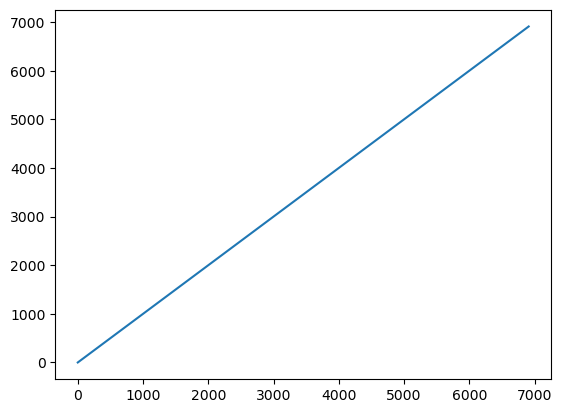

In [223]:
def solve(eps):
    am, bm = {0: 0.3}, {0: 1}
    
    def d(t):
        return max(0, min((a(t) - 1 + b(t))/(1 + b(t)), 1 - (1 - a(t) - eps) / 0.7))
    
    def a(t):
        if t in am: return am[t]
        am[t] = eps + a(t-1) - d(t-1)
        return am[t]
    
    def b(t):
        if t in bm: return bm[t]
        bm[t] = b(t-1) * (1 - d(t-1))
        return bm[t]
    
    t = 0
    while max(a(t), 1 - b(t)) < 1 - eps:
        t += 1
        # print(a(t), b(t))
    return t

min_del = 0.001
eps = np.arange(min_del, 1, min_del)
plt.figure()
plt.plot(1. / eps * np.log(1. / eps), [solve(x) for x in eps])
plt.show()

x = 1. / eps * np.log(1. / eps)
y = np.array([solve(x) for x in eps])

In [218]:
print(x[-1], y[-1])

0.0010015018354190411 0


In [9]:
from keras import datasets

mnist = datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
x_validate, y_validate = x_test[:-10], y_test[:-10]
x_test, y_test = x_test[-10:], y_test[-10:]

11501568/11490434 [==============================] - 1s 0us/step


In [10]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)
